In [2]:
import pandas as pd
import requests
import shutil
import errno
import os

savepath = "datasets/"

In [3]:
# Renfe Horarios de alta velocidad, larga distancia y media distancia
url = 'https://ssl.renfe.com/gtransit/Fichero_AV_LD/google_transit.zip'

flags = os.O_CREAT | os.O_EXCL | os.O_WRONLY

# Download zip file
req = requests.get(url)

# Get file name from url
filename = url.split('/')[-1]

if not os.path.exists(savepath):
   os.makedirs(savepath)

try:
    file_handle = os.open(savepath+filename, flags)
except OSError as e:
    if e.errno == errno.EEXIST:  # Failed as the file already exists.
        print('File already exists!')
    else:  # Something unexpected went wrong so reraise the exception.
        raise
else:  # No exception, so the file must have been created successfully.
    # Writing the file to the local file system
    with open(savepath+filename, 'wb') as output_file:
        output_file.write(req.content)

    # Unzip
    shutil.unpack_archive(savepath+filename, savepath)

    print('File downloaded successfully!')

File already exists!


In [4]:
renfe_schedules = {}

for filename in os.listdir(savepath):
    if filename.endswith('.txt'):
        renfe_schedules[filename.split(".")[0]] = pd.read_csv(savepath+filename, delimiter=',')

In [5]:
renfe_schedules['stops']

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,71801,NaN,Barcelona-Sants,NaN,41.379220,2.140624,NaN,NaN,NaN,NaN,Europe/Madrid,1
1,61307,NaN,Cartagena,NaN,37.604967,-0.975122,NaN,NaN,NaN,NaN,Europe/Madrid,1
2,61304,NaN,Torre-Pacheco,NaN,37.746905,-0.967078,NaN,NaN,NaN,NaN,Europe/Madrid,2
3,61303,NaN,Balsicas-Mar Menor,NaN,37.818840,-0.950891,NaN,NaN,NaN,NaN,Europe/Madrid,2
4,61200,NaN,Murcia,NaN,37.974650,-1.129955,NaN,NaN,NaN,NaN,Europe/Madrid,1
...,...,...,...,...,...,...,...,...,...,...,...,...
797,34008,NaN,Narros del Castillo,NaN,40.866641,-5.052869,NaN,NaN,NaN,NaN,Europe/Madrid,2
798,34007,NaN,Crespos,NaN,40.870110,-4.968030,NaN,NaN,NaN,NaN,Europe/Madrid,2
799,34005,NaN,San Pedro del Arroyo,NaN,40.803841,-4.871407,NaN,NaN,NaN,NaN,Europe/Madrid,2
800,34002,NaN,Cardenyosa de Avila,NaN,40.739120,-4.750750,NaN,NaN,NaN,NaN,Europe/Madrid,2


In [6]:
df = renfe_schedules['stops']

stopsD = dict(zip(df.stop_name, zip(df.stop_id, zip(df.stop_lat, df.stop_lon))))

stopsD['Murcia']

(61200, (37.97465, -1.1299555))

In [7]:
# Install cartopy - if necessary via IDE
#!pip install cartopy==0.18.0

# Install geopandas - if necessary
#!pip install geopandas

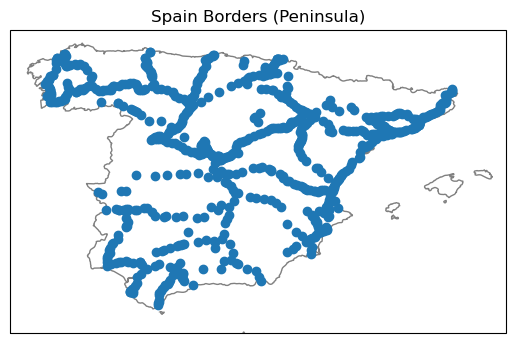

In [8]:
from cartopy.io import shapereader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas

# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shapefilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shapefilename)

# read Spain borders
poly = df.loc[df['ADMIN'] == 'Spain']['geometry'].values[0]

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.5')

# Scatter plot each station (lat, lon)
stopsCoords = [(float(stopsD[s][1][1]), float(stopsD[s][1][0])) for s in stopsD]
x, y = zip(*stopsCoords)
ax.scatter(x, y)

bounds= poly.bounds # minx, miny, maxx, maxy
# (-18.167225714999915, 27.642238674000055, 4.337087436000047, 43.79344310100004)
bounds = list(bounds)
bounds[0] = -9.4
bounds[1] = 35.7
m = 0.4 # Margin
bounds = [l - m if i < 2 else l + m for i, l in enumerate(bounds)]

ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])

ax.set_title("Spain Borders (Peninsula)")
plt.show()

In [9]:
cd ..

/Users/david/PycharmProjects/robin


In [10]:
from src.robin.offer.entities import *

s = Station(0, "MAD", "Madrid")

print(s)

[0,MAD,Madrid,None]


In [11]:
M = Station(int(stopsD['Murcia'][0]), 'Murcia', 'MUR', stopsD['Murcia'][1])

print(M)

[61200,Murcia,MUR,(37.97465, -1.1299555)]


In [12]:
df = renfe_schedules['stops']

df['stop_id'] = df['stop_id'].astype(int)
df['stop_lat'] = df['stop_lat'].astype(float)
df['stop_lon'] = df['stop_lon'].astype(float)

stopsD = dict(zip(df.stop_id, zip(df.stop_name, zip(df.stop_lon, df.stop_lat))))

stations = [Station(int(s), stopsD[s][0], str(str(s)[:3].upper()), stopsD[s][1]) for s in stopsD]

print(stations[1])

[61307,Cartagena,613,(-0.975122, 37.604967)]


In [13]:
type(stopsD[61307][1])

tuple

In [14]:
# Build train stop list for each trip
df = renfe_schedules['stop_times']

set_trip_ids = set(df['trip_id'].values)

routes = {}
for tid in set_trip_ids:
    df_lock = df.loc[df['trip_id'] == tid]
    routes[tid] = tuple(df_lock['stop_id'].values)

In [15]:
longest_trip = max(routes.values(), key=lambda v: len(v))
print(longest_trip)

(17000, 70200, 70202, 70204, 70207, 70208, 70209, 70210, 70300, 70302, 70400, 70401, 70403, 70500, 70600, 4040, 70806, 70807, 71100, 71105, 71108, 71200, 71201, 71204, 71207, 71208, 71209, 71210, 71211, 71300, 71302, 71303, 71307, 71400, 71401, 71500, 71502, 71503, 71600, 71700, 71801, 71802, 79400)


In [16]:
stopsCoords = [stopsD[s][1] for s in longest_trip]
stopsCoords.append(stopsD[longest_trip[-1]][1])
print(stopsCoords)

[(-3.6824687, 40.4720993), (-3.1822298, 40.6441032), (-3.163226, 40.747013), (-3.13886, 40.831273), (-3.073157, 40.909686), (-3.014352, 40.90598), (-2.935935, 40.930229), (-2.84326, 40.953808), (-2.785635, 41.004864), (-2.646407, 41.071417), (-2.492952, 41.136617), (-2.421241, 41.165207), (-2.278998, 41.215854), (-2.059411, 41.3098), (-1.63868, 41.346692), (-0.911615, 41.658649), (-0.89466, 41.651563), (-0.891188, 41.644103), (-0.863064, 41.62977), (-0.490673, 41.419528), (-0.427115, 41.320542), (-0.438595, 41.2244), (-0.368761, 41.182183), (-0.042701, 41.239738), (0.242472, 41.213788), (0.350275, 41.225247), (0.480888, 41.248451), (0.540071, 41.229502), (0.568964, 41.182479), (0.652893, 41.106374), (0.78033, 41.102057), (0.810328, 41.130945), (1.020774, 41.165525), (1.099979, 41.160524), (1.150389, 41.112744), (1.253214, 41.111624), (1.37453, 41.136446), (1.40566, 41.142857), (1.526315, 41.186245), (1.733331, 41.219993), (2.140624, 41.37922), (2.164896, 41.392281), (2.187004, 41.38408

In [18]:
%matplotlib notebook
from cartopy.io import shapereader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas

# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shapefilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shapefilename)

# read Spain borders
poly = df.loc[df['ADMIN'] == 'Spain']['geometry'].values[0]

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.5')

x, y = zip(*stopsCoords)
ax.scatter(x, y)

for i, _ in enumerate(range(len(stopsCoords)-1)):
    ax.annotate(text='', xy=stopsCoords[i+1], xytext=stopsCoords[i], arrowprops=dict(arrowstyle='->'))

bounds = poly.bounds # minx, miny, max_x, max_y
# (-18.167225714999915, 27.642238674000055, 4.337087436000047, 43.79344310100004)
bounds = list(bounds)
bounds[0] = -9.4
bounds[1] = 35.7
m = 0.4 # Margin
bounds = [l - m if i < 2 else l + m for i, l in enumerate(bounds)]

ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])

ax.set_title("Spain Borders (Peninsula)")
plt.show()

<IPython.core.display.Javascript object>

In [3]:
# date = '2%20h.%2030%20min.'

date = '2h.30min.'

hours = date.split("h.")[0]
mins = date.split("h.")[1][:-4]

datef = "%20".join([hours, "h.", mins, "min."])
print(datef)

2%20h.%2030%20min.


In [ ]:
train = {('03171', 'AVE'): ('17.00', '19.30', '2h.30min.', {0: '107.35', 1: '120.80', 2: '143.95'})}

train.

In [37]:
import difflib
import pandas as pd
import re

renfe_stations = pd.read_csv('renfe_stations.csv', sep=',')
name = "MADRID PTA ATOCHA ALMUDENA GRANDES"
name = name.lower()
print("Name: ", name)

gtfs_names = renfe_stations['stop_name'].values.tolist()
gtfs_names = list(map(lambda s: s.lower(), gtfs_names))
gtfs_names = list(map(lambda s: re.sub(r'[-/]', ' ', s), gtfs_names))
#print("GTFS names: ", gtfs_names)

best_match = "Unknown"
bml = 0
for gn in gtfs_names:
    gnl = gn.split(" ")

    if sum([True for w in name.split(" ") if w in gnl]) > bml:
        best_match = gn

print(best_match)

i = gtfs_names.index(best_match)
print(i)

station_id = renfe_stations.iloc[i]['stop_id']
print(station_id)

Name:  madrid pta atocha almudena grandes
madrid puerta de atocha
76
60000
